In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "uni80"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 215
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 287
Categorical Columns: 8


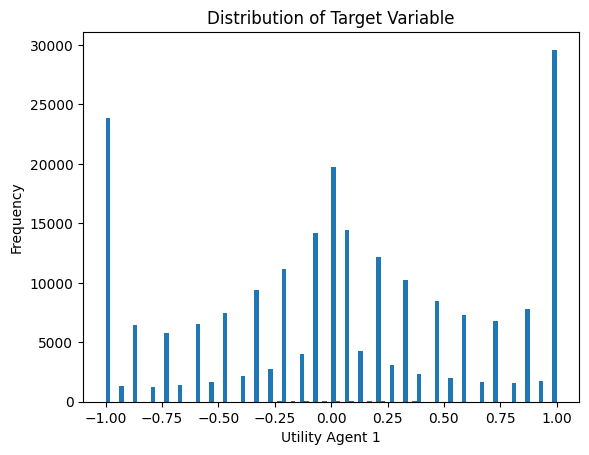

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55371


[100]	val-rmse:0.46784


[200]	val-rmse:0.44805


[300]	val-rmse:0.43839


[400]	val-rmse:0.43349


[500]	val-rmse:0.43029


[600]	val-rmse:0.42862


[700]	val-rmse:0.42740


[800]	val-rmse:0.42663


[900]	val-rmse:0.42584


[1000]	val-rmse:0.42521


[1100]	val-rmse:0.42502


[1200]	val-rmse:0.42491


[1300]	val-rmse:0.42467


[1400]	val-rmse:0.42467


[1500]	val-rmse:0.42462


[1600]	val-rmse:0.42451


[1700]	val-rmse:0.42455


[1800]	val-rmse:0.42441


[1900]	val-rmse:0.42454


[2000]	val-rmse:0.42452


[2100]	val-rmse:0.42446


[2200]	val-rmse:0.42451


[2300]	val-rmse:0.42461


[2400]	val-rmse:0.42464


[2499]	val-rmse:0.42464


Fold 1 - RMSE: 0.4243374546917745
Fold 2


[0]	val-rmse:0.58728


[100]	val-rmse:0.48016


[200]	val-rmse:0.46282


[300]	val-rmse:0.45468


[400]	val-rmse:0.45134


[500]	val-rmse:0.44901


[600]	val-rmse:0.44789


[700]	val-rmse:0.44685


[800]	val-rmse:0.44617


[900]	val-rmse:0.44558


[1000]	val-rmse:0.44500


[1100]	val-rmse:0.44490


[1200]	val-rmse:0.44463


[1300]	val-rmse:0.44438


[1400]	val-rmse:0.44415


[1500]	val-rmse:0.44398


[1600]	val-rmse:0.44385


[1700]	val-rmse:0.44376


[1800]	val-rmse:0.44364


[1900]	val-rmse:0.44361


[2000]	val-rmse:0.44364


[2100]	val-rmse:0.44368


[2200]	val-rmse:0.44366


[2300]	val-rmse:0.44366


[2400]	val-rmse:0.44359


[2499]	val-rmse:0.44345


Fold 2 - RMSE: 0.44308134760002804
Fold 3


[0]	val-rmse:0.60575


[100]	val-rmse:0.48332


[200]	val-rmse:0.46438


[300]	val-rmse:0.45626


[400]	val-rmse:0.45230


[500]	val-rmse:0.44955


[600]	val-rmse:0.44749


[700]	val-rmse:0.44603


[800]	val-rmse:0.44525


[900]	val-rmse:0.44479


[1000]	val-rmse:0.44411


[1100]	val-rmse:0.44354


[1200]	val-rmse:0.44307


[1300]	val-rmse:0.44277


[1400]	val-rmse:0.44247


[1500]	val-rmse:0.44228


[1600]	val-rmse:0.44219


[1700]	val-rmse:0.44215


[1800]	val-rmse:0.44206


[1900]	val-rmse:0.44197


[2000]	val-rmse:0.44193


[2100]	val-rmse:0.44189


[2200]	val-rmse:0.44188


[2300]	val-rmse:0.44194


[2400]	val-rmse:0.44195


[2499]	val-rmse:0.44187


Fold 3 - RMSE: 0.4413453889195459
Fold 4


[0]	val-rmse:0.59523


[100]	val-rmse:0.47965


[200]	val-rmse:0.45998


[300]	val-rmse:0.45070


[400]	val-rmse:0.44623


[500]	val-rmse:0.44357


[600]	val-rmse:0.44166


[700]	val-rmse:0.44065


[800]	val-rmse:0.43953


[900]	val-rmse:0.43887


[1000]	val-rmse:0.43851


[1100]	val-rmse:0.43808


[1200]	val-rmse:0.43794


[1300]	val-rmse:0.43768


[1400]	val-rmse:0.43755


[1500]	val-rmse:0.43739


[1600]	val-rmse:0.43718


[1700]	val-rmse:0.43716


[1800]	val-rmse:0.43701


[1900]	val-rmse:0.43694


[2000]	val-rmse:0.43704


[2100]	val-rmse:0.43707


[2200]	val-rmse:0.43709


[2300]	val-rmse:0.43709


[2400]	val-rmse:0.43704


[2499]	val-rmse:0.43700


Fold 4 - RMSE: 0.43653162845380117
Fold 5


[0]	val-rmse:0.54734


[100]	val-rmse:0.45443


[200]	val-rmse:0.43228


[300]	val-rmse:0.42154


[400]	val-rmse:0.41681


[500]	val-rmse:0.41322


[600]	val-rmse:0.41148


[700]	val-rmse:0.41006


[800]	val-rmse:0.40913


[900]	val-rmse:0.40812


[1000]	val-rmse:0.40770


[1100]	val-rmse:0.40722


[1200]	val-rmse:0.40690


[1300]	val-rmse:0.40660


[1400]	val-rmse:0.40627


[1500]	val-rmse:0.40605


[1600]	val-rmse:0.40591


[1700]	val-rmse:0.40587


[1800]	val-rmse:0.40580


[1900]	val-rmse:0.40572


[2000]	val-rmse:0.40573


[2100]	val-rmse:0.40564


[2200]	val-rmse:0.40561


[2300]	val-rmse:0.40554


[2400]	val-rmse:0.40556


[2499]	val-rmse:0.40564


Fold 5 - RMSE: 0.40535009155923846
List of oof scores: [0.4243374546917745, 0.44308134760002804, 0.4413453889195459, 0.43653162845380117, 0.40535009155923846]
Average oof score: 0.4301291822448777


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53575


[100]	val-rmse:0.45275


[200]	val-rmse:0.43572


[300]	val-rmse:0.42764


[400]	val-rmse:0.42399


[500]	val-rmse:0.42144


[600]	val-rmse:0.41958


[700]	val-rmse:0.41829


[800]	val-rmse:0.41742


[900]	val-rmse:0.41653


[1000]	val-rmse:0.41587


[1100]	val-rmse:0.41529


[1200]	val-rmse:0.41489


[1300]	val-rmse:0.41465


[1400]	val-rmse:0.41445


[1500]	val-rmse:0.41411


[1600]	val-rmse:0.41388


[1700]	val-rmse:0.41377


[1800]	val-rmse:0.41355


[1900]	val-rmse:0.41351


[2000]	val-rmse:0.41349


[2100]	val-rmse:0.41332


[2200]	val-rmse:0.41325


[2300]	val-rmse:0.41323


[2400]	val-rmse:0.41322


[2499]	val-rmse:0.41320


Fold 1 - RMSE: 0.4129770440957206
Fold 2


[0]	val-rmse:0.54489


[100]	val-rmse:0.43219


[200]	val-rmse:0.41740


[300]	val-rmse:0.41062


[400]	val-rmse:0.40765


[500]	val-rmse:0.40578


[600]	val-rmse:0.40471


[700]	val-rmse:0.40431


[800]	val-rmse:0.40417


[900]	val-rmse:0.40370


[1000]	val-rmse:0.40357


[1100]	val-rmse:0.40358


[1200]	val-rmse:0.40342


[1300]	val-rmse:0.40342


[1400]	val-rmse:0.40333


[1500]	val-rmse:0.40329


[1600]	val-rmse:0.40341


[1700]	val-rmse:0.40340


[1800]	val-rmse:0.40353


[1900]	val-rmse:0.40362


[2000]	val-rmse:0.40361


[2100]	val-rmse:0.40366


[2200]	val-rmse:0.40375


[2300]	val-rmse:0.40373


[2400]	val-rmse:0.40376


[2499]	val-rmse:0.40386


Fold 2 - RMSE: 0.4031039433093961
Fold 3


[0]	val-rmse:0.61248


[100]	val-rmse:0.48647


[200]	val-rmse:0.46251


[300]	val-rmse:0.45279


[400]	val-rmse:0.44779


[500]	val-rmse:0.44401


[600]	val-rmse:0.44184


[700]	val-rmse:0.44036


[800]	val-rmse:0.43901


[900]	val-rmse:0.43796


[1000]	val-rmse:0.43728


[1100]	val-rmse:0.43653


[1200]	val-rmse:0.43601


[1300]	val-rmse:0.43568


[1400]	val-rmse:0.43547


[1500]	val-rmse:0.43526


[1600]	val-rmse:0.43496


[1700]	val-rmse:0.43482


[1800]	val-rmse:0.43456


[1900]	val-rmse:0.43469


[2000]	val-rmse:0.43454


[2100]	val-rmse:0.43445


[2200]	val-rmse:0.43433


[2300]	val-rmse:0.43422


[2400]	val-rmse:0.43415


[2499]	val-rmse:0.43410


Fold 3 - RMSE: 0.43372296776172975
Fold 4


[0]	val-rmse:0.60444


[100]	val-rmse:0.48391


[200]	val-rmse:0.46140


[300]	val-rmse:0.45199


[400]	val-rmse:0.44741


[500]	val-rmse:0.44485


[600]	val-rmse:0.44269


[700]	val-rmse:0.44147


[800]	val-rmse:0.44046


[900]	val-rmse:0.43993


[1000]	val-rmse:0.43957


[1100]	val-rmse:0.43894


[1200]	val-rmse:0.43855


[1300]	val-rmse:0.43821


[1400]	val-rmse:0.43810


[1500]	val-rmse:0.43802


[1600]	val-rmse:0.43787


[1700]	val-rmse:0.43784


[1800]	val-rmse:0.43771


[1900]	val-rmse:0.43773


[2000]	val-rmse:0.43764


[2100]	val-rmse:0.43757


[2200]	val-rmse:0.43748


[2300]	val-rmse:0.43739


[2400]	val-rmse:0.43724


[2499]	val-rmse:0.43727


Fold 4 - RMSE: 0.43690240358556487
Fold 5


[0]	val-rmse:0.59007


[100]	val-rmse:0.47849


[200]	val-rmse:0.45389


[300]	val-rmse:0.44373


[400]	val-rmse:0.43784


[500]	val-rmse:0.43445


[600]	val-rmse:0.43256


[700]	val-rmse:0.43081


[800]	val-rmse:0.42979


[900]	val-rmse:0.42911


[1000]	val-rmse:0.42830


[1100]	val-rmse:0.42798


[1200]	val-rmse:0.42763


[1300]	val-rmse:0.42744


[1400]	val-rmse:0.42737


[1500]	val-rmse:0.42719


[1600]	val-rmse:0.42707


[1700]	val-rmse:0.42703


[1800]	val-rmse:0.42705


[1900]	val-rmse:0.42689


[2000]	val-rmse:0.42683


[2100]	val-rmse:0.42690


[2200]	val-rmse:0.42692


[2300]	val-rmse:0.42678


[2400]	val-rmse:0.42669


[2499]	val-rmse:0.42670


Fold 5 - RMSE: 0.4261776940882028
List of oof scores: [0.4129770440957206, 0.4031039433093961, 0.43372296776172975, 0.43690240358556487, 0.4261776940882028]
Average oof score: 0.42257681056812285


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57432


[100]	val-rmse:0.47562


[200]	val-rmse:0.45637


[300]	val-rmse:0.44781


[400]	val-rmse:0.44354


[500]	val-rmse:0.44133


[600]	val-rmse:0.43975


[700]	val-rmse:0.43866


[800]	val-rmse:0.43785


[900]	val-rmse:0.43752


[1000]	val-rmse:0.43689


[1100]	val-rmse:0.43651


[1200]	val-rmse:0.43624


[1300]	val-rmse:0.43590


[1400]	val-rmse:0.43587


[1500]	val-rmse:0.43576


[1600]	val-rmse:0.43569


[1700]	val-rmse:0.43556


[1800]	val-rmse:0.43548


[1900]	val-rmse:0.43551


[2000]	val-rmse:0.43550


[2100]	val-rmse:0.43558


[2200]	val-rmse:0.43559


[2300]	val-rmse:0.43551


[2400]	val-rmse:0.43551


[2499]	val-rmse:0.43556


Fold 1 - RMSE: 0.4350478052915087
Fold 2


[0]	val-rmse:0.57374


[100]	val-rmse:0.46500


[200]	val-rmse:0.44149


[300]	val-rmse:0.43116


[400]	val-rmse:0.42549


[500]	val-rmse:0.42185


[600]	val-rmse:0.41937


[700]	val-rmse:0.41800


[800]	val-rmse:0.41702


[900]	val-rmse:0.41622


[1000]	val-rmse:0.41551


[1100]	val-rmse:0.41520


[1200]	val-rmse:0.41489


[1300]	val-rmse:0.41459


[1400]	val-rmse:0.41441


[1500]	val-rmse:0.41425


[1600]	val-rmse:0.41406


[1700]	val-rmse:0.41403


[1800]	val-rmse:0.41400


[1900]	val-rmse:0.41392


[2000]	val-rmse:0.41384


[2100]	val-rmse:0.41375


[2200]	val-rmse:0.41375


[2300]	val-rmse:0.41353


[2400]	val-rmse:0.41339


[2499]	val-rmse:0.41333


Fold 2 - RMSE: 0.41304111425042306
Fold 3


[0]	val-rmse:0.57637


[100]	val-rmse:0.46526


[200]	val-rmse:0.44709


[300]	val-rmse:0.43814


[400]	val-rmse:0.43366


[500]	val-rmse:0.43119


[600]	val-rmse:0.42947


[700]	val-rmse:0.42824


[800]	val-rmse:0.42743


[900]	val-rmse:0.42678


[1000]	val-rmse:0.42607


[1100]	val-rmse:0.42567


[1200]	val-rmse:0.42549


[1300]	val-rmse:0.42505


[1400]	val-rmse:0.42482


[1500]	val-rmse:0.42463


[1600]	val-rmse:0.42457


[1700]	val-rmse:0.42454


[1800]	val-rmse:0.42439


[1900]	val-rmse:0.42434


[2000]	val-rmse:0.42428


[2100]	val-rmse:0.42425


[2200]	val-rmse:0.42429


[2300]	val-rmse:0.42424


[2400]	val-rmse:0.42427


[2499]	val-rmse:0.42430


Fold 3 - RMSE: 0.42394765447254495
Fold 4


[0]	val-rmse:0.57427


[100]	val-rmse:0.45639


[200]	val-rmse:0.43661


[300]	val-rmse:0.42786


[400]	val-rmse:0.42363


[500]	val-rmse:0.42092


[600]	val-rmse:0.41889


[700]	val-rmse:0.41780


[800]	val-rmse:0.41712


[900]	val-rmse:0.41645


[1000]	val-rmse:0.41588


[1100]	val-rmse:0.41553


[1200]	val-rmse:0.41526


[1300]	val-rmse:0.41518


[1400]	val-rmse:0.41485


[1500]	val-rmse:0.41480


[1600]	val-rmse:0.41471


[1700]	val-rmse:0.41448


[1800]	val-rmse:0.41440


[1900]	val-rmse:0.41432


[2000]	val-rmse:0.41428


[2100]	val-rmse:0.41438


[2200]	val-rmse:0.41431


[2300]	val-rmse:0.41434


[2400]	val-rmse:0.41428


[2499]	val-rmse:0.41437


Fold 4 - RMSE: 0.4140114126183477
Fold 5


[0]	val-rmse:0.58576


[100]	val-rmse:0.47645


[200]	val-rmse:0.45590


[300]	val-rmse:0.44600


[400]	val-rmse:0.44039


[500]	val-rmse:0.43707


[600]	val-rmse:0.43465


[700]	val-rmse:0.43308


[800]	val-rmse:0.43192


[900]	val-rmse:0.43097


[1000]	val-rmse:0.43044


[1100]	val-rmse:0.42986


[1200]	val-rmse:0.42949


[1300]	val-rmse:0.42904


[1400]	val-rmse:0.42907


[1500]	val-rmse:0.42877


[1600]	val-rmse:0.42857


[1700]	val-rmse:0.42840


[1800]	val-rmse:0.42835


[1900]	val-rmse:0.42816


[2000]	val-rmse:0.42816


[2100]	val-rmse:0.42820


[2200]	val-rmse:0.42811


[2300]	val-rmse:0.42796


[2400]	val-rmse:0.42791


[2499]	val-rmse:0.42788


Fold 5 - RMSE: 0.42749043796601593
List of oof scores: [0.4350478052915087, 0.41304111425042306, 0.42394765447254495, 0.4140114126183477, 0.42749043796601593]
Average oof score: 0.42270768491976807


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4243
Score: 0.4431
Score: 0.4413
Score: 0.4365
Score: 0.4054
Average CV1 Score: 0.4301

CV2 OOF Scores:
Score: 0.4130
Score: 0.4031
Score: 0.4337
Score: 0.4369
Score: 0.4262
Average CV2 Score: 0.4226

CV3 OOF Scores:
Score: 0.4350
Score: 0.4130
Score: 0.4239
Score: 0.4140
Score: 0.4275
Average CV3 Score: 0.4227


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

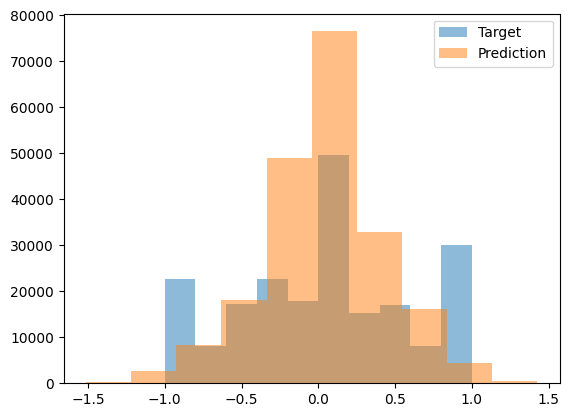

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***